# CIC-IDS-2018 - Multi-class Classification

By: Luis David Garcia

Part of my final project for the course is to implement a hybrid Autoencoder-XGBoost learning model to classify network traffic data for distributed denial of serivce (DDoS) attacks. The dataset used is the CIC-IDS-2018 dataset, focusing specifcally on the days they were attacked by DDoS attacks. The dataset is available at: https://www.unb.ca/cic/datasets/ids-2018.html

## Conda Environment Setup

This is likely not necessary if you run the code online in Google Colab, but if you want to run the code locally, you can create a conda environment with the following commands:

In [ ]:
#!/bin/bash

# Variables
ENV_NAME="myenv"
PYTHON_VERSION="3.10"

# Create the conda environment
%conda create --name $ENV_NAME python=$PYTHON_VERSION -y
# Initialize the Bash shell for conda environments
!@source "$(conda info --base)/etc/profile.d/conda.sh"
# Activate the conda environment
%conda activate $ENV_NAME

# Install TensorFlow
%conda install -c conda-forge tensorflow -y

# Install scikit-learn and XGBoost
%conda install -c conda-forge scikit-learn xgboost -y

# Install additional libraries
%conda install -c conda-forge numpy pandas matplotlib imbalanced-learn psutil seaborn jupyter -y

# Output success message
!echo "Conda environment '$ENV_NAME' has been set up with all dependencies."


## Imports

In [1]:
# For getting paths
import os

# For data manipulation and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# For feature engineering
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# For model building
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For timing
import time

# For Deep Learning
import tensorflow as tf

## Acquire Data

In [2]:
# Read the CSV file into a dataframe
combined_df = pd.read_csv("/Users/lucky/GitHub/DDoS-Hybrid-Detection-System/datasets/cic_ids_2018/cicids2018-ddos.csv")

## Data Preprocessing

In [3]:
# Get general information about the dataframe
print("Before preprocessing:")
print(combined_df.info())
print("--------------------------")
print(combined_df.head())
print("--------------------------")
print(combined_df.shape)

Before preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2978160 entries, 0 to 2978159
Data columns (total 80 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   Protocol           int64  
 2   Timestamp          object 
 3   Flow Duration      int64  
 4   Tot Fwd Pkts       int64  
 5   Tot Bwd Pkts       int64  
 6   TotLen Fwd Pkts    int64  
 7   TotLen Bwd Pkts    int64  
 8   Fwd Pkt Len Max    int64  
 9   Fwd Pkt Len Min    int64  
 10  Fwd Pkt Len Mean   float64
 11  Fwd Pkt Len Std    float64
 12  Bwd Pkt Len Max    int64  
 13  Bwd Pkt Len Min    int64  
 14  Bwd Pkt Len Mean   float64
 15  Bwd Pkt Len Std    float64
 16  Flow Byts/s        float64
 17  Flow Pkts/s        float64
 18  Flow IAT Mean      float64
 19  Flow IAT Std       float64
 20  Flow IAT Max       int64  
 21  Flow IAT Min       int64  
 22  Fwd IAT Tot        int64  
 23  Fwd IAT Mean       float64
 24  Fwd IAT Std        float64
 

### Removal of Duplicates, NANs, and Infs

In [4]:
# Maintain a copy of the original dataframe
original_df = combined_df.copy()

# Remove duplicates
combined_df.drop_duplicates(inplace=True)
# Replace infinity with NaN
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Remove columns with all NaN values
combined_df.dropna(axis=1, how='all', inplace=True)
# Remove rows with any NaN values
combined_df.dropna(inplace=True)
# Acquire column names that contain object data types
object_cols = combined_df.select_dtypes(include=['object']).columns

In [5]:
# Get rid of timestamp to not overgeneralize on specific time periods
combined_df.drop('Timestamp', axis=1, inplace=True)

In [6]:
# Show updated information about the dataframe
print("After preprocessing:")
print(combined_df.info())
print("--------------------------")
print(combined_df.head())
print("--------------------------")
print(combined_df.shape)

After preprocessing:
<class 'pandas.core.frame.DataFrame'>
Index: 2970138 entries, 0 to 2978159
Data columns (total 79 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   Protocol           int64  
 2   Flow Duration      int64  
 3   Tot Fwd Pkts       int64  
 4   Tot Bwd Pkts       int64  
 5   TotLen Fwd Pkts    int64  
 6   TotLen Bwd Pkts    int64  
 7   Fwd Pkt Len Max    int64  
 8   Fwd Pkt Len Min    int64  
 9   Fwd Pkt Len Mean   float64
 10  Fwd Pkt Len Std    float64
 11  Bwd Pkt Len Max    int64  
 12  Bwd Pkt Len Min    int64  
 13  Bwd Pkt Len Mean   float64
 14  Bwd Pkt Len Std    float64
 15  Flow Byts/s        float64
 16  Flow Pkts/s        float64
 17  Flow IAT Mean      float64
 18  Flow IAT Std       float64
 19  Flow IAT Max       int64  
 20  Flow IAT Min       int64  
 21  Fwd IAT Tot        int64  
 22  Fwd IAT Mean       float64
 23  Fwd IAT Std        float64
 24  Fwd IAT Max        int64  
 25  Fw

### Train/Test Split (80/20)

In [7]:
X = combined_df.drop('Label', axis=1)
y = combined_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Helper function to add bar labels
def add_bar_labels(bars):
    # Add counts on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height}',
            ha='center',
            va='bottom'
        )

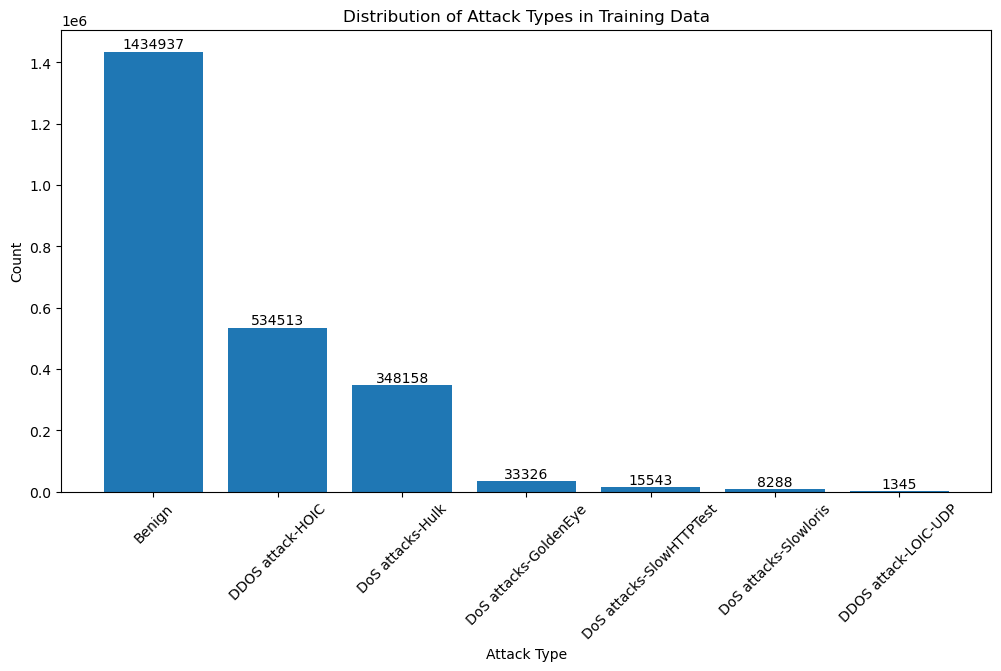

In [9]:
# Check the distribution of the labels in training data
train_attack_counts = y_train.value_counts()
plt.figure(figsize=(12,6))
bars = plt.bar(train_attack_counts.index, train_attack_counts.values)
add_bar_labels(bars)
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.title("Distribution of Attack Types in Training Data")
plt.xticks(rotation=45)
plt.show()

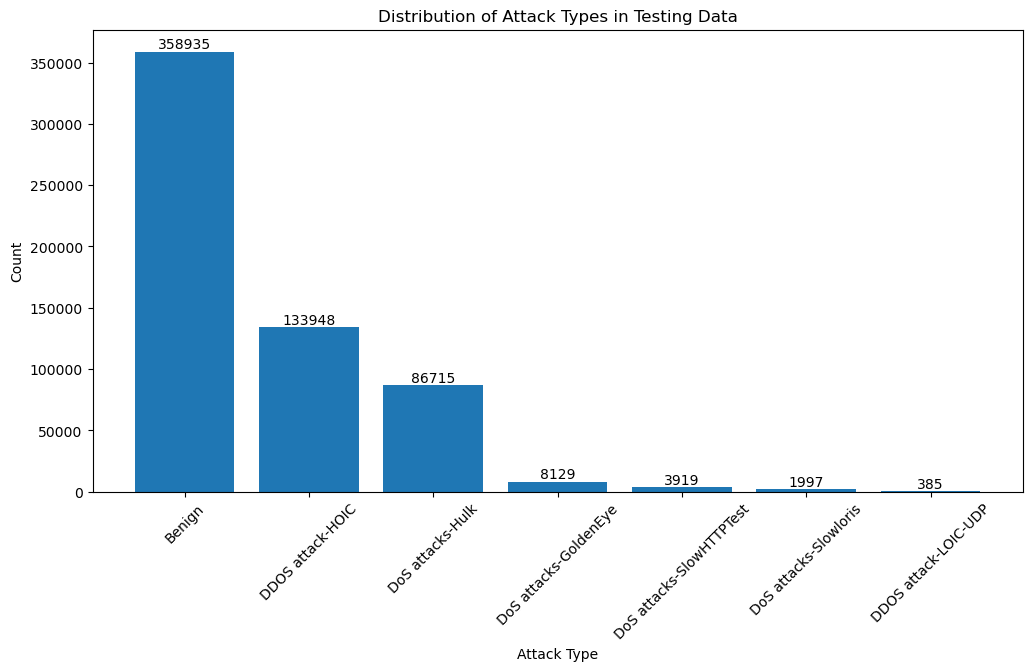

In [10]:
# Check the distribution of the labels in test data
test_attack_counts = y_test.value_counts()
plt.figure(figsize=(12,6))
bars = plt.bar(test_attack_counts.index, test_attack_counts.values)
add_bar_labels(bars)
plt.xlabel("Attack Type")
plt.ylabel("Count") 
plt.title("Distribution of Attack Types in Testing Data")
plt.xticks(rotation=45)
plt.show()

## Feature Engineering

In [11]:
# Mutual information feature selection
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

Init Fwd Win Byts    0.946574
Fwd Header Len       0.764196
Fwd Seg Size Avg     0.594005
Fwd Pkt Len Mean     0.593496
Fwd IAT Mean         0.586020
                       ...   
Fwd Pkts/b Avg       0.000000
CWE Flag Count       0.000000
Bwd Byts/b Avg       0.000000
Fwd Blk Rate Avg     0.000000
Fwd Byts/b Avg       0.000000
Length: 78, dtype: float64

<Axes: >

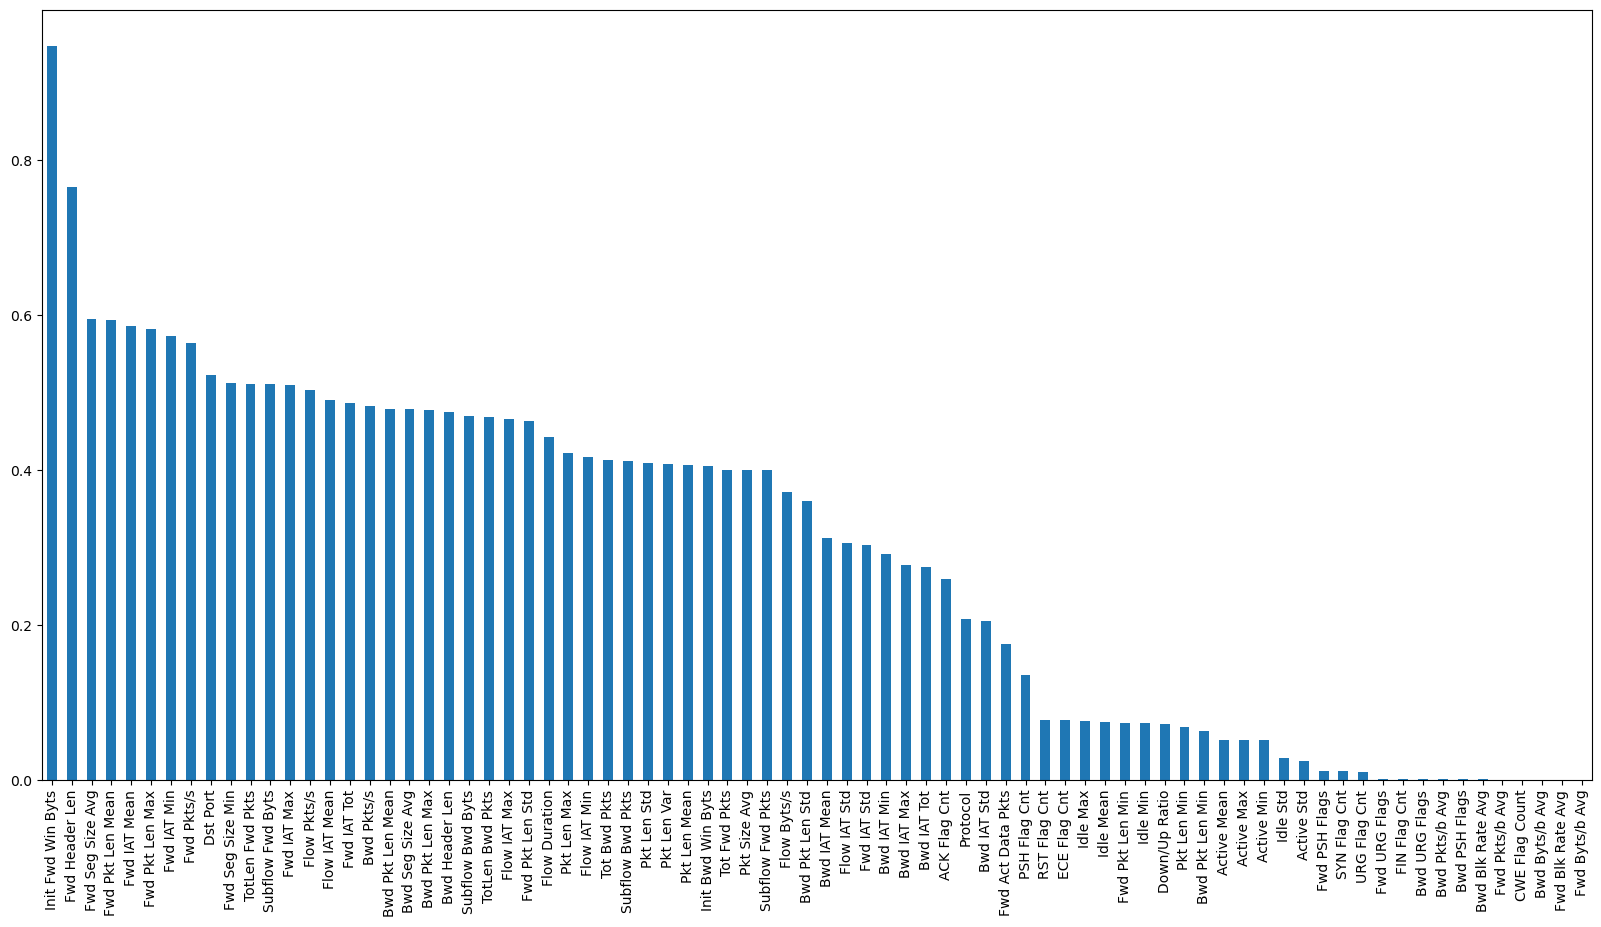

In [12]:
# Display in bar chart
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20,10))

In [13]:
# SelectKBest for Top 20 Features
top_20_features = SelectKBest(mutual_info_classif, k=4)
top_20_features.fit(X_train, y_train)
X_train.columns[top_20_features.get_support()]

Index(['Fwd Pkt Len Mean', 'Fwd Header Len', 'Fwd Seg Size Avg',
       'Init Fwd Win Byts'],
      dtype='object')

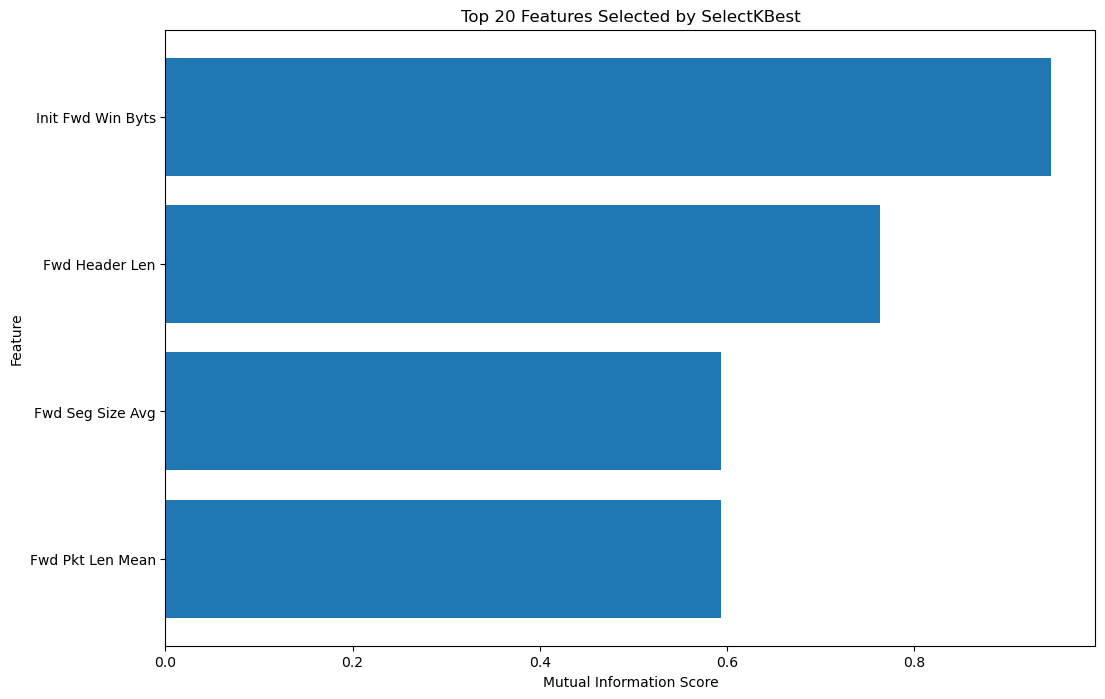

In [14]:
# Get the mask for the selected features
mask = top_20_features.get_support()

# Get the feature scores
feature_scores = top_20_features.scores_

# Get the selected feature names
selected_features = X_train.columns[mask]
selected_scores = feature_scores[mask]

# Create a DataFrame for plotting
df_top_features = pd.DataFrame({
    'Feature': selected_features,
    'Score': selected_scores
})

# Sort the DataFrame by scores in descending order
df_top_features = df_top_features.sort_values(by='Score', ascending=False)

# Plot the top features
plt.figure(figsize=(12, 8))
plt.barh(df_top_features['Feature'], df_top_features['Score'])
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Top 20 Features Selected by SelectKBest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()


In [15]:
top_20_features = ['Fwd Pkt Len Mean', 'Fwd Header Len', 'Fwd Seg Size Avg',
       'Init Fwd Win Byts']

# ['Dst Port', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean',
#        'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Flow IAT Mean',
#        'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min',
#        'Fwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Fwd Seg Size Avg',
#        'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Init Fwd Win Byts',
#        'Fwd Seg Size Min']

X_train=X_train[top_20_features]
X_test=X_test[top_20_features]

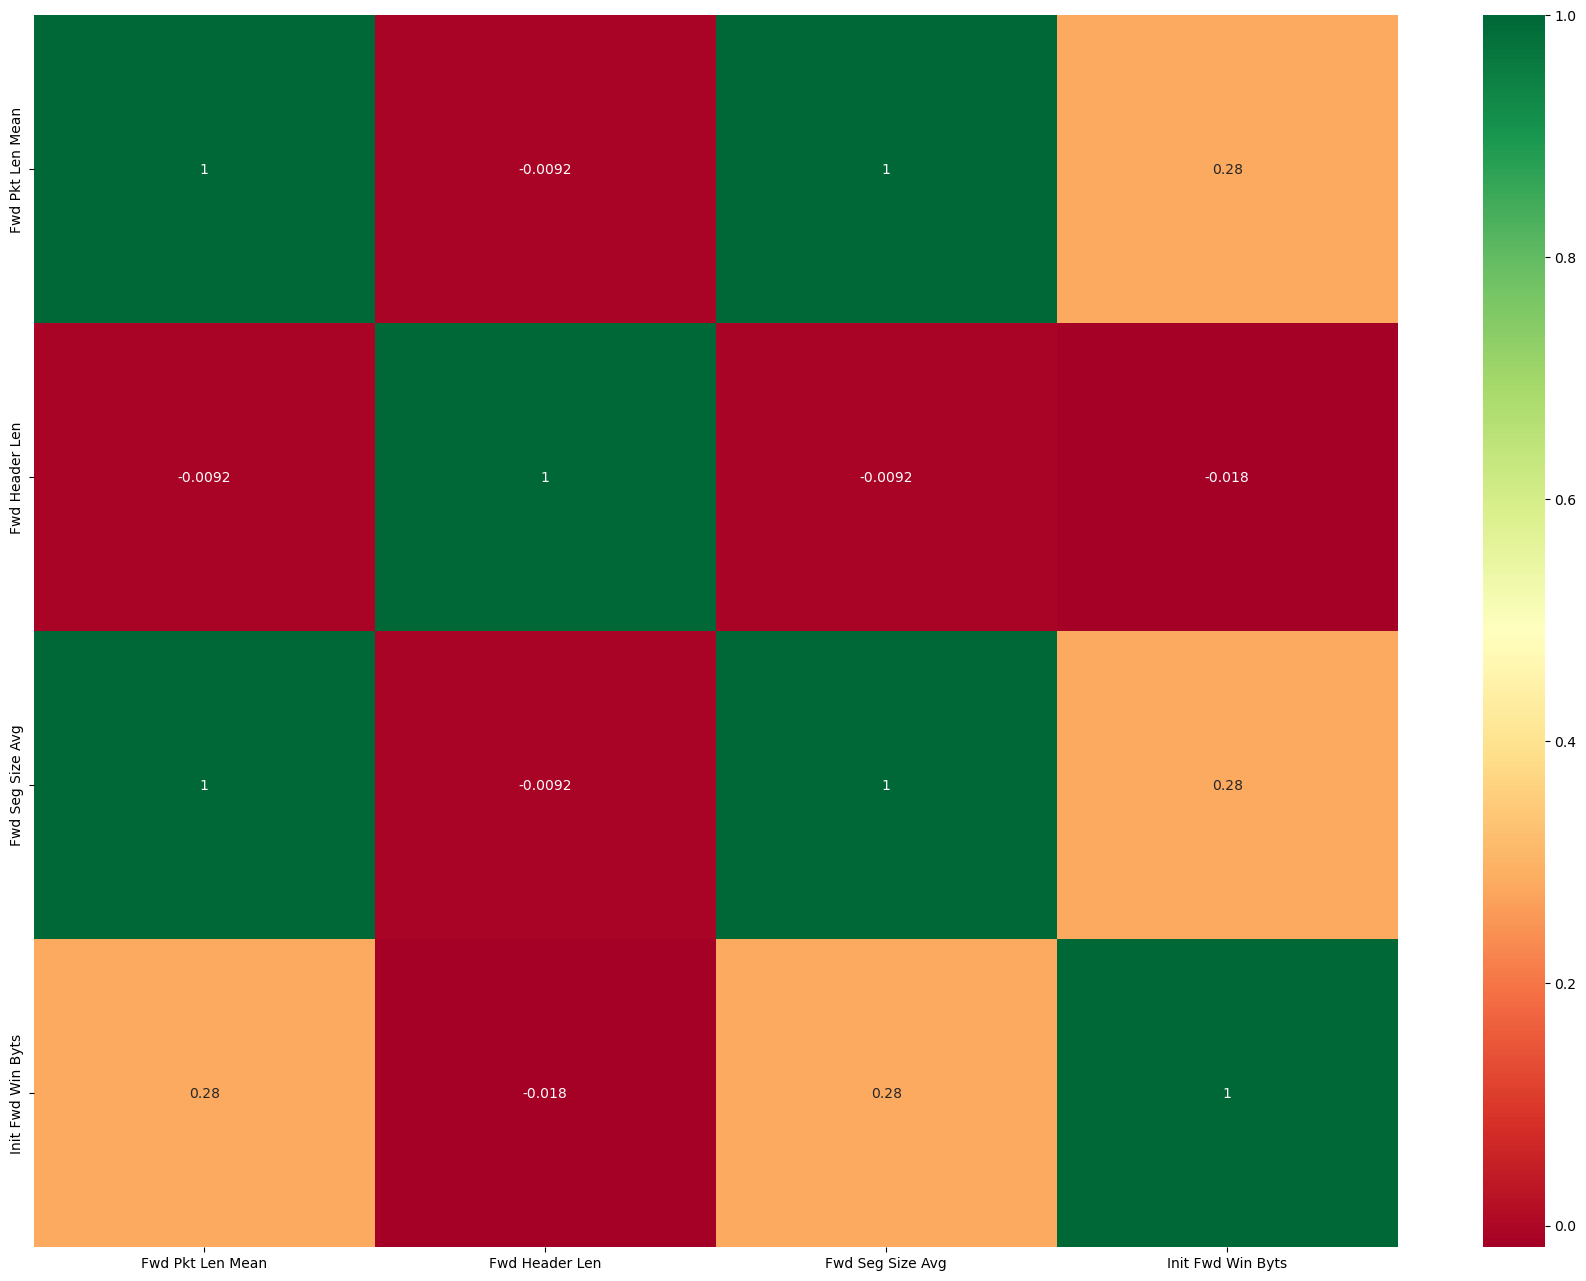

In [16]:
plt.figure(figsize=(22,16))
top_20_heatmap = sns.heatmap(X_train.corr(), annot=True, cmap='RdYlGn')

### Encoding and Scaling

In [17]:
# Scale and Encode Data
scaler = StandardScaler()
le = LabelEncoder()

# Fit and transform the training data
X_train = scaler.fit_transform(X_train)
y_train = le.fit_transform(y_train)
# Transform the testing data
X_test = scaler.transform(X_test)
y_test = le.transform(y_test)

In [18]:
print(X_train.shape, y_train.shape)

(2376110, 4) (2376110,)


## Results of Traditional Models for Multi-Class Classification

In [19]:
# Create the classifiers
models = {
    "XGBoost": XGBClassifier(
        objective='multi:softprob',
        num_class=len(le.classes_),
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Decision Tree": DecisionTreeClassifier(),
}


# Train and evaluate each model
results = {}

for name, model in models.items():
    # Train the model
    start_train_time = time.time()
    model.fit(X_train, y_train)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Predict on the test set
    start_pred_time = time.time()
    y_pred = model.predict(X_test)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time

    # Decode labels for evaluation
    y_test_decoded = le.inverse_transform(y_test)
    y_pred_decoded = le.inverse_transform(y_pred)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
    precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
    class_report = classification_report(y_test_decoded, y_pred_decoded, zero_division=1)

    # Store the results
    results[name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "conf_matrix": conf_matrix,
        "class_report": class_report,
        "train_time": train_time,
        "pred_time": pred_time
    }

    # Print evaluation metrics
    print(f'--- {name} ---')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Classification Report:\n{class_report}')
    print(f'Training Time: {train_time} seconds')
    print(f'Prediction Time: {pred_time} seconds')


--- XGBoost ---
Accuracy: 0.9997474866504609
Precision: 0.9969595176950997
Recall: 0.9979121861337765
F1 Score: 0.9974332324292935
Confusion Matrix:
[[358905     16      0      3      1      5      5]
 [     0 133948      0      0      0      0      0]
 [     0      0    385      0      0      0      0]
 [     0      0      0   8112      3      0     14]
 [     0      0      0     80  86635      0      0]
 [     0      0      0      0      0   3919      0]
 [    22      0      0      1      0      0   1974]]
Classification Report:
                          precision    recall  f1-score   support

                  Benign       1.00      1.00      1.00    358935
        DDOS attack-HOIC       1.00      1.00      1.00    133948
    DDOS attack-LOIC-UDP       1.00      1.00      1.00       385
   DoS attacks-GoldenEye       0.99      1.00      0.99      8129
        DoS attacks-Hulk       1.00      1.00      1.00     86715
DoS attacks-SlowHTTPTest       1.00      1.00      1.00      3919


### Confusion Matricies

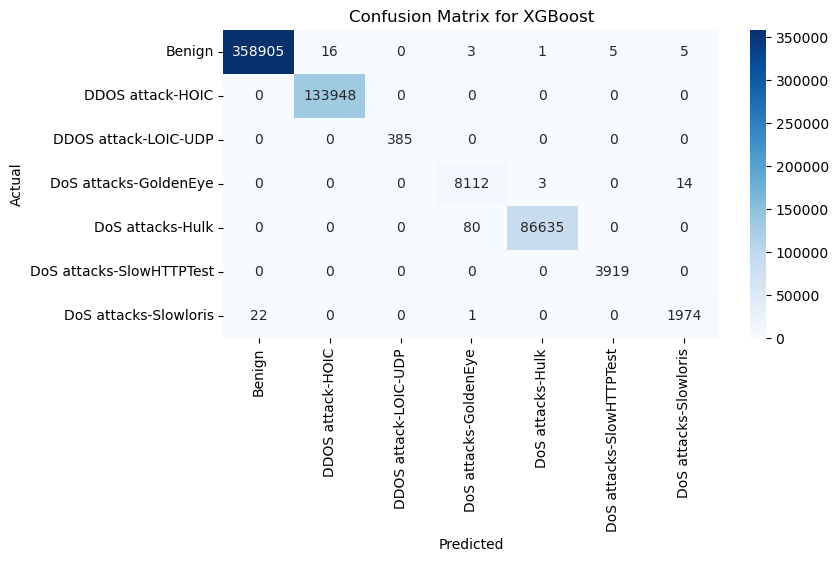

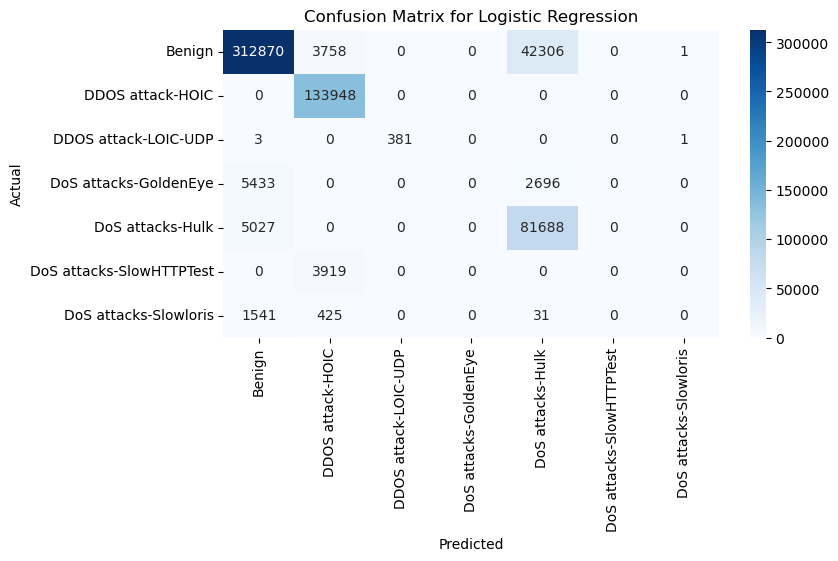

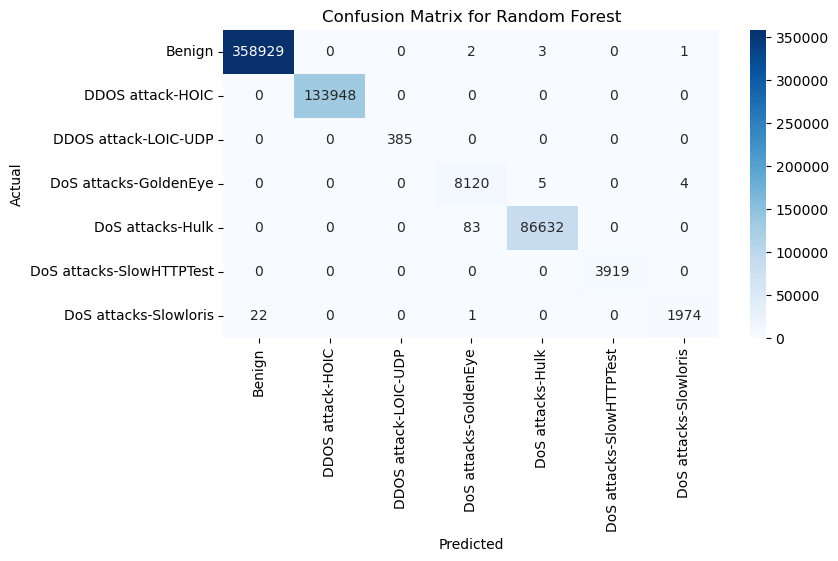

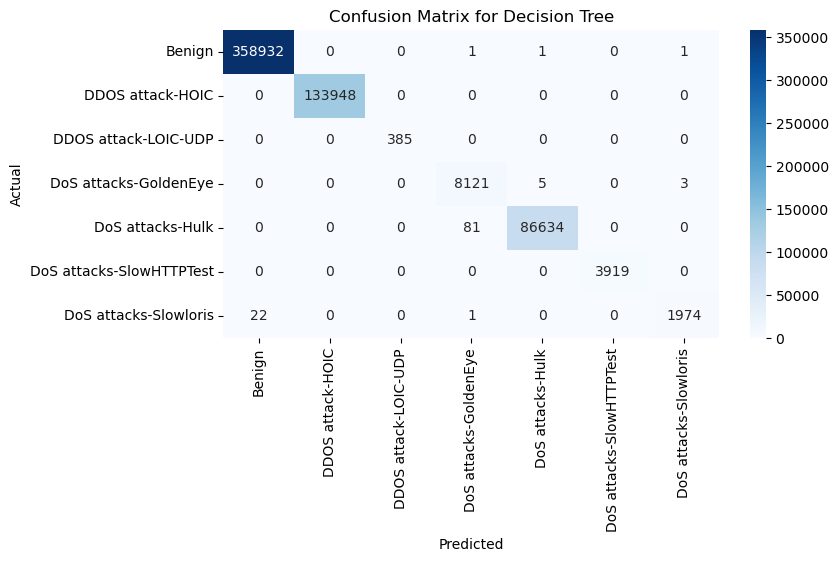

In [26]:
# Plot the confusion matrix for each model
for model_name, metrics in results.items():
    plt.figure(figsize=(8, 4))
    sns.heatmap(metrics['conf_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

## Autoencoder-XGB

In [41]:
import tensorflow as tf

input_dim = X_train.shape[1]

# Reshape data for Conv1D
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the autoencoder model
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim, 1)),
    tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu', name='bottleneck'),
    tf.keras.layers.Dense(((input_dim // 4)) * 16, activation='relu'),
    tf.keras.layers.Reshape(((input_dim // 4), 16)),
    tf.keras.layers.UpSampling1D(2),
    tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.UpSampling1D(2),
    tf.keras.layers.Conv1D(1, 3, activation='tanh', padding='same')
])

# Compile the autoencoder
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Print the model summary
print(autoencoder.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │         1,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 16)         │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 1)          │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,169 (20.19 KB)

 Trainable params: 5,169 (20.19 KB)

 Non-trainable params: 0 (0.00 B)

None


### Training of Autoencoder

In [21]:
autoencoder_start_time = time.time()
# Train the autoencoder on both benign and attack samples
autoencoder.fit(
    X_train_reshaped, 
    X_train_reshaped, 
    epochs=100, 
    batch_size=64, 
    shuffle=True, 
    validation_split=0.2,
)
autoencoder_end_time = time.time()
autoencoder_training_time = autoencoder_end_time - autoencoder_start_time


Epoch 1/100
29702/29702 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.5410 - val_loss: 0.5134
Epoch 2/100
29702/29702 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step - loss: 0.5286 - val_loss: 0.5128
Epoch 3/100
29702/29702 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.5434 - val_loss: 0.5127
Epoch 4/100
29702/29702 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.5461 - val_loss: 0.5127
Epoch 5/100
29702/29702 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.5205 - val_loss: 0.5126
Epoch 6/100
29702/29702 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - loss: 0.5335 - val_loss: 0.5124
Epoch 7/100
29702/29702 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.5328 - val_loss: 0.5123
Epoch 8/100
29702/29702 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.5341 - val_loss: 0.5124
Epoch 9/100
29702/29702 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step - loss: 0.5340 - val_loss: 0.5124
Epoch 10/100
29702/29702 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 0.5398 - val_loss: 0.5124
Epoch 11/100
29702/29702 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 0.5255 - val

In [28]:
# Save the trained autoencoder model
autoencoder.save('cicids2018_trained_autoencoder.keras')

# Extract the encoder part
encoder = tf.keras.Sequential(autoencoder.layers[:7])
encoder.build(input_shape=(None, input_dim, 1))

# Print the encoder model summary
print(encoder.summary())

# Save the encoder model
encoder.save('cicids2018_trained_encoder.keras')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │         1,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,336 (16.94 KB)

 Trainable params: 4,336 (16.94 KB)

 Non-trainable params: 0 (0.00 B)

None


### Run This Cell Only if You Want to Use the Pretrained Encoder

In [43]:
# Load the encoder model
encoder = tf.keras.models.load_model('cicids2018_trained_encoder.keras')

In [44]:
# Encode the train and test data using the trained encoder
encoded_train = encoder.predict(X_train_reshaped)
encoded_test = encoder.predict(X_test_reshaped)

74254/74254 ━━━━━━━━━━━━━━━━━━━━ 44s 589us/step
18564/18564 ━━━━━━━━━━━━━━━━━━━━ 11s 568us/step


In [ ]:
# Flatten the encoded data for combining
encoded_train_flat = encoded_train.reshape((encoded_train.shape[0], -1))
encoded_test_flat = encoded_test.reshape((encoded_test.shape[0], -1))

In [31]:
# Print the shape of the encoded data
print(f'Encoded train shape: {encoded_train_flat.shape}')
print(f'Encoded test shape: {encoded_test_flat.shape}')

Encoded train shape: (2376110, 80)
Encoded test shape: (594028, 80)


## Results of Autoencoder-XGB

In [32]:
# Create the XGBoost classifier
model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False
)

# Train the model
start_train_time = time.time()
eval_set = [(encoded_train_flat, y_train), (encoded_test_flat, y_test)]
model.fit(encoded_train_flat, y_train, verbose=True)
end_train_time = time.time()
train_time = end_train_time - start_train_time

# Predict on the test set
start_pred_time = time.time()
y_pred = model.predict(encoded_test_flat)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time

# Decode labels for evaluation
y_test_decoded = le.inverse_transform(y_test)
y_pred_decoded = le.inverse_transform(y_pred)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
class_report = classification_report(y_test_decoded, y_pred_decoded, zero_division=1)

# Store the results
results = {}
results["xgboost"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "conf_matrix": conf_matrix,
    "class_report": class_report,
    "train_time": train_time,
    "pred_time": pred_time
}

# Print evaluation metrics
print(f'--- {"xgboost"} ---')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')
print(f'Training Time: {train_time} seconds')
print(f'Prediction Time: {pred_time} seconds')

--- xgboost ---
Accuracy: 0.9999562310194132
Precision: 0.999553588216802
Recall: 0.9992831428427918
F1 Score: 0.9994182630544037
Confusion Matrix:
[[358925      1      0      2      3      1      3]
 [     0 133948      0      0      0      0      0]
 [     0      0    385      0      0      0      0]
 [     2      0      0   8121      4      0      2]
 [     0      0      0      0  86715      0      0]
 [     0      0      0      0      0   3919      0]
 [     8      0      0      0      0      0   1989]]
Classification Report:
                          precision    recall  f1-score   support

                  Benign       1.00      1.00      1.00    358935
        DDOS attack-HOIC       1.00      1.00      1.00    133948
    DDOS attack-LOIC-UDP       1.00      1.00      1.00       385
   DoS attacks-GoldenEye       1.00      1.00      1.00      8129
        DoS attacks-Hulk       1.00      1.00      1.00     86715
DoS attacks-SlowHTTPTest       1.00      1.00      1.00      3919
 

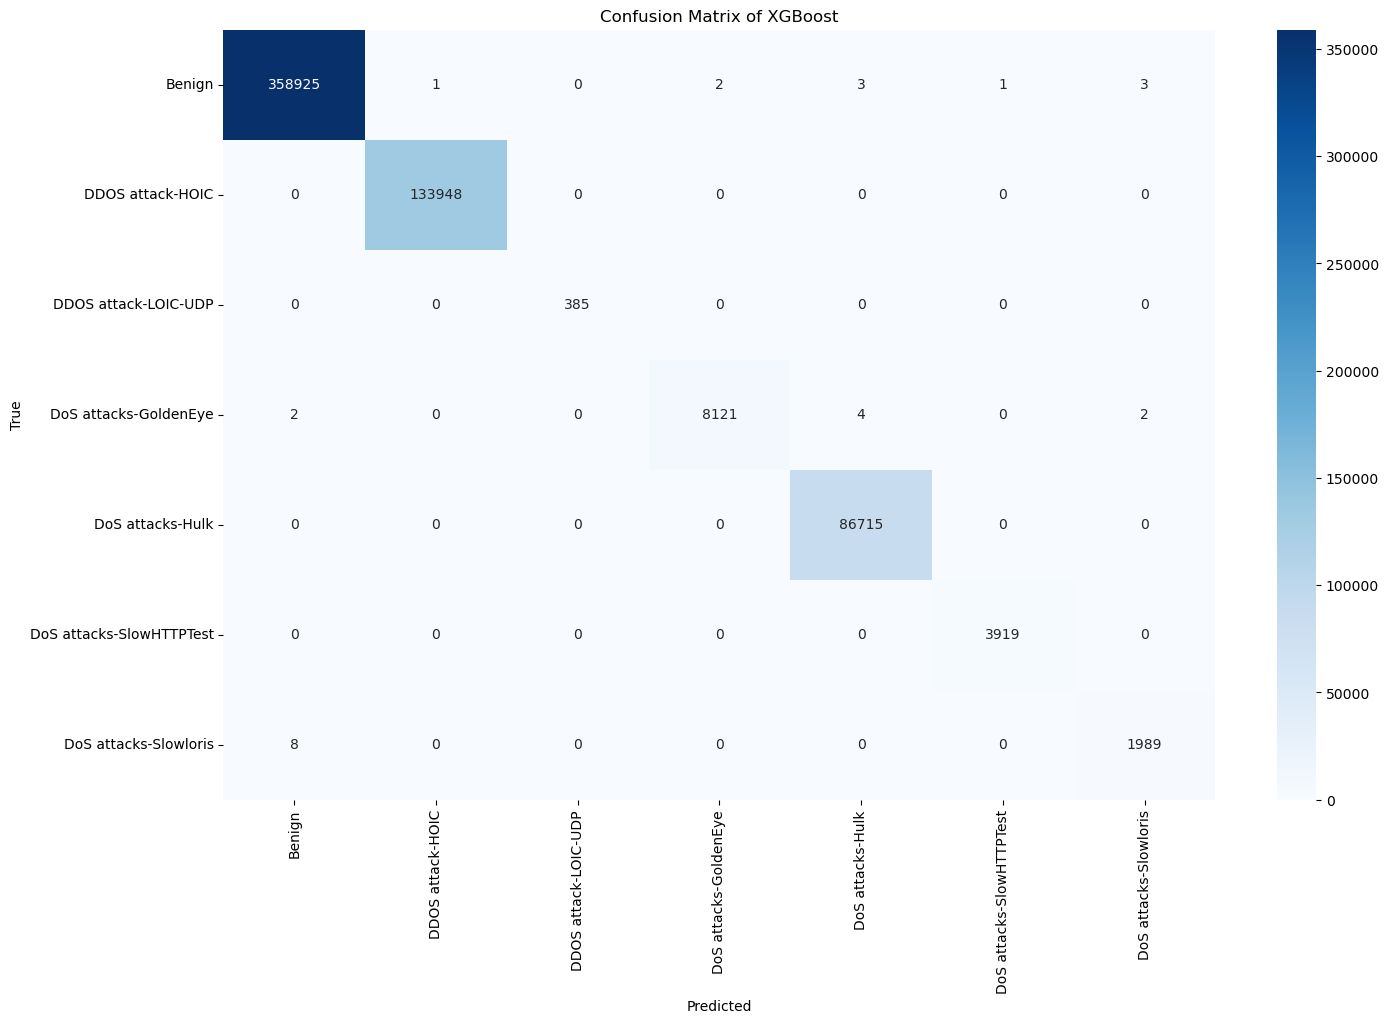

In [26]:
# Plot confusion matrix
plt.figure(figsize=(16, 10))
sns.heatmap(results['xgboost']['conf_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of XGBoost')
plt.show()

## CNN-LSTM

In [16]:
# Reshape x_train and x_test to 3D for CNN-LSTM
x_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # shape becomes (125973, 20, 1)
x_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))      # shape becomes (22544, 20, 1)

In [17]:
num_classes = 7  # Adjust this based on your actual number of classes

cnn_lstm_model = tf.keras.models.Sequential([
    # Input shape is (20 time steps, 1 feature per time step)
    tf.keras.layers.Input(shape=(X_train.shape[1], 1)),
    
    # CNN Layers with adjusted pooling
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),  # This reduces the time steps from 20 to 10
    
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),  # This reduces the time steps from 10 to 5
    
    # LSTM Layers
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100),
    
    # Fully Connected Layers
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    # Output layer for multiclass classification
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Softmax for multiclass classification
])

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
cnn_lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 18, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,407 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,159 (754.53 KB)

 Trainable params: 193,159 (754.53 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Convert y_train and y_test to one-hot encoding
y_train_reshaped = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_reshaped = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

print(y_train_reshaped.shape)  # Should print (125973, 7)
print(y_test_reshaped.shape)   # Should print (22544, 7)


(2376110, 7)
(594028, 7)


In [19]:
import time

# Record the start time
start_time = time.time()

# Train the model
history = cnn_lstm_model.fit(x_train_reshaped, y_train_reshaped, epochs=30, batch_size=64, validation_data=(x_test_reshaped, y_test_reshaped))

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/30
37127/37127 ━━━━━━━━━━━━━━━━━━━━ 477s 13ms/step - accuracy: 0.8418 - loss: 0.3186 - val_accuracy: 0.8543 - val_loss: 0.2615
Epoch 2/30
37127/37127 ━━━━━━━━━━━━━━━━━━━━ 448s 12ms/step - accuracy: 0.8797 - loss: 0.2455 - val_accuracy: 0.8477 - val_loss: 0.2877
Epoch 3/30
37127/37127 ━━━━━━━━━━━━━━━━━━━━ 412s 11ms/step - accuracy: 0.8705 - loss: 0.2548 - val_accuracy: 0.8541 - val_loss: 0.2613
Epoch 4/30
37127/37127 ━━━━━━━━━━━━━━━━━━━━ 405s 11ms/step - accuracy: 0.8775 - loss: 0.2458 - val_accuracy: 0.8452 - val_loss: 0.2872
Epoch 5/30
37127/37127 ━━━━━━━━━━━━━━━━━━━━ 431s 12ms/step - accuracy: 0.8701 - loss: 0.2517 - val_accuracy: 0.8801 - val_loss: 0.2336
Epoch 6/30
37127/37127 ━━━━━━━━━━━━━━━━━━━━ 430s 12ms/step - accuracy: 0.8783 - loss: 0.2388 - val_accuracy: 0.8526 - val_loss: 0.2727
Epoch 7/30
37127/37127 ━━━━━━━━━━━━━━━━━━━━ 441s 12ms/step - accuracy: 0.8770 - loss: 0.2433 - val_accuracy: 0.8512 - val_loss: 0.2762
Epoch 8/30
37127/37127 ━━━━━━━━━━━━━━━━━━━━ 450s 12ms/s

In [20]:
# Make predictions on the test data
start_pred_time = time.time()
y_pred = cnn_lstm_model.predict(x_test_reshaped)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time
print(f"Prediction time: {pred_time:.2f} seconds")

# Convert predictions from probabilities to class labels (argmax to get the index of the max probability)
y_pred_classes = np.argmax(y_pred, axis=1)

# y_test is one-hot encoded, so you need to reverse that
y_true_classes = np.argmax(y_test_reshaped, axis=1)

# Decode the integer-encoded labels back to the original categorical labels using LabelEncoder
y_pred_decoded = le.inverse_transform(y_pred_classes)
y_test_decoded = le.inverse_transform(y_true_classes)

# Print the decoded predictions and true labels
print("Predicted Labels:", y_pred_decoded)
print("True Labels:", y_test_decoded)


18564/18564 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step
Prediction time: 46.98 seconds
Predicted Labels: ['DDOS attack-HOIC' 'Benign' 'Benign' ... 'DDOS attack-HOIC'
 'DDOS attack-HOIC' 'DDOS attack-HOIC']
True Labels: ['DDOS attack-HOIC' 'Benign' 'Benign' ... 'DDOS attack-HOIC'
 'DDOS attack-HOIC' 'DDOS attack-HOIC']


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision (macro-average): {precision:.5f}")
print(f"Recall (macro-average): {recall:.5f}")
print(f"F1 Score (macro-average): {f1:.5f}")

Accuracy: 0.99559
Precision (macro-average): 0.97404
Recall (macro-average): 0.98709
F1 Score (macro-average): 0.98024


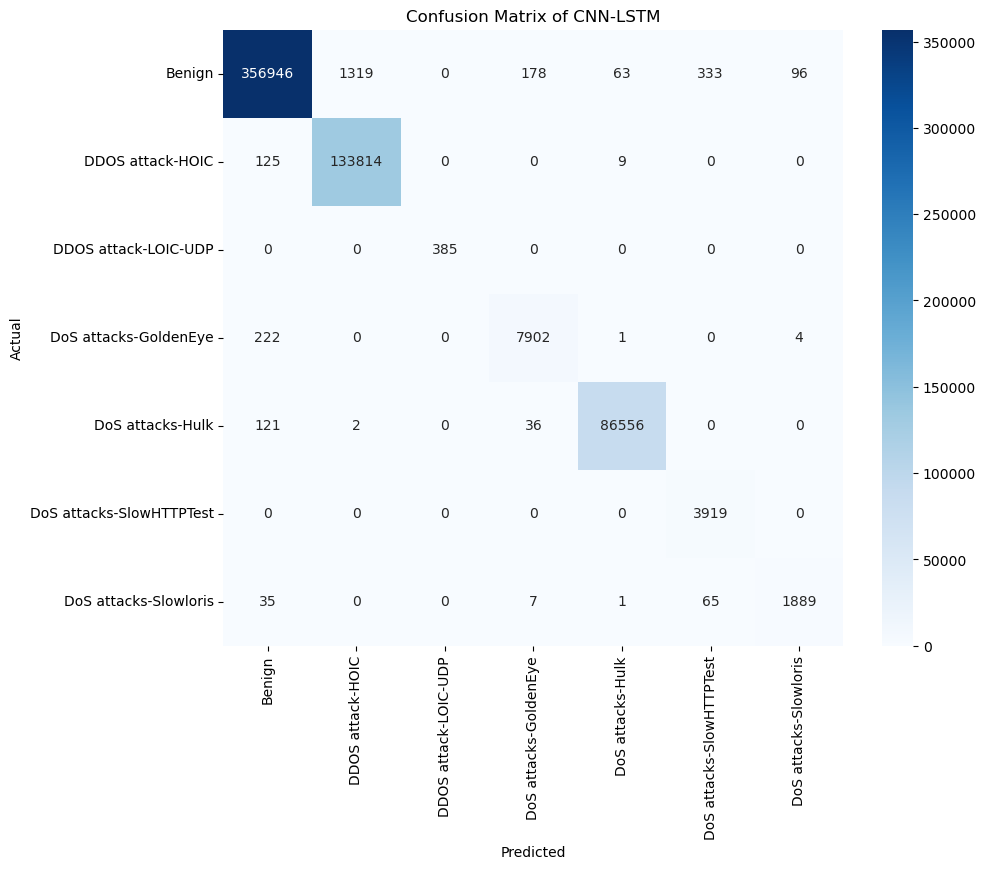

                          precision    recall  f1-score   support

                  Benign    0.99859   0.99446   0.99652    358935
        DDOS attack-HOIC    0.99022   0.99900   0.99459    133948
    DDOS attack-LOIC-UDP    1.00000   1.00000   1.00000       385
   DoS attacks-GoldenEye    0.97279   0.97208   0.97243      8129
        DoS attacks-Hulk    0.99915   0.99817   0.99866     86715
DoS attacks-SlowHTTPTest    0.90781   1.00000   0.95168      3919
   DoS attacks-Slowloris    0.94972   0.94592   0.94782      1997

                accuracy                        0.99559    594028
               macro avg    0.97404   0.98709   0.98024    594028
            weighted avg    0.99567   0.99559   0.99561    594028



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

# Define the number of classes (assuming le.classes_ gives the correct number of classes)
num_classes = len(le.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of CNN-LSTM')
plt.show()

# Print the classification report
print(classification_report(y_test_decoded, y_pred_decoded, digits=5))